In [55]:
from sympy import *
init_printing()
from IPython.display import display
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
import matplotlib.animation as animation
%matplotlib notebook
# specify a second time as a workaround to get interactive plots working
%matplotlib notebook
#reload(gaussian_orbitals)
import gaussian_orbitals
import read_qmcpack
#reload(read_qmcpack)
import numpy as np
import scipy.optimize
from ipywidgets import interact
import ipywidgets

### Cusp Correction for Gaussian Orbitals

From "Scheme for adding electron-nucleus cusps to Gaussian orbitals" A. Ma, D. Towler, N. D. Drummond, R. J. Needs, Journal of Chemical Physics 122, 224322(2005) https://doi.org/10.1063/1.1940588


In [2]:
phi = Symbol('phi')
phi_t = Symbol('phitilde')
eta = Symbol('eta')
psi = Symbol('psi')
psi_t = Symbol('psitilde')
phi, phi_t, eta, psi, psi_t

Each orbital can be divided into two parts - the s-type functions on the current center, and everything else.
* $\phi$ The s-type functions on the current center (original functions, no cusp correction)
* $\eta$ All non-s-type functions on the current center, and all functions from other centers (no need for cusp correction)
* $\psi$ Total uncorrected orbital ($ = \phi  + \eta$)
* $\tilde{\phi}$  Cusp-corrected s-type functions on the current center
* $\tilde{\psi}$ Total cusp-corrected orbital ($ = \tilde{\phi} + \eta$)

Inside some cutoff radius ($r_c$) the s-type part of the orbital is replaced with (Eqn 7 in the paper):

In [3]:
C = Symbol('C')
p = Symbol('p')
p_sym = p
r = Symbol('r',real=True,nonnegative=True)
R = Symbol('R')
eq_phi1 = Eq(phi_t, C + sign(phi_t(0))*exp(p(r)))
eq_R = Eq(R(r), sign(phi_t(0))*exp(p(r)))
eq_phi2 = Eq(phi_t, C + R(r))
display(eq_phi1)
display(eq_R)
display(eq_phi2)


In [4]:
alpha = IndexedBase('alpha',shape=(5,))

Where $p$ is a polynomial with the $\alpha$'s as coefficients

In [5]:
p = alpha[0] + alpha[1]*r + alpha[2]*r**2 + alpha[3]*r**3 + alpha[4]*r**4
Eq(p_sym, p)

In [6]:
rc = Symbol('r_c')

In [7]:
R_def = exp(p)
R_def

### Solve for polynomial coefficients
Now to express the $\alpha$'s in terms of various contraints on the wavefunction (The value of the wavefunction and derivatives at the constraint points are the $X$'s)

In [8]:
X1,X2,X3,X4,X5 = symbols('X_1 X_2 X_3 X_4 X_5')
# Constraints
# Value of phi tilde matches orbital at r_c
eq1 = Eq(p.subs(r,rc), X1)
eq1

In [9]:
# derivative of phi tilde matches orbital at r_c
eq2 = Eq(diff(p,r).subs(r,rc), X2)
eq2

In [10]:
# 2nd derivative of phi tilde matches orbital at r_c
eq3 = Eq((diff(p,r,2)+diff(p,r)**2).subs(r,rc),X3)
eq3

In [11]:
# Cusp condition - derivative at zero
eq4 = Eq(diff(p,r).subs(r,0),X4)
eq4

In [12]:
# Value of phi tilde at 0
eq5 = Eq(p.subs(r,0),X5)
eq5

Solve for the polynomial coefficients ($\alpha$'s) in terms of the wavefunction and derivative values ($X$'s).   These should match Eqn 14  in the paper.

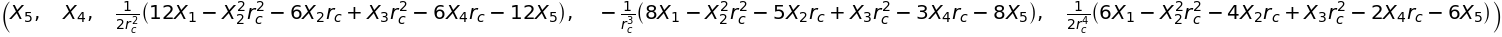

In [13]:
sln = solve([eq1, eq2, eq3, eq4, eq5],[alpha[0], alpha[1], alpha[2], alpha[3], alpha[4]])[0]
sln

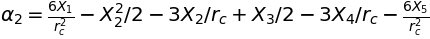

In [14]:
Eq(alpha[2],simplify(sln[2]))

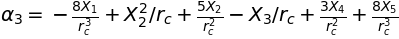

In [15]:
Eq(alpha[3],expand(sln[3]))

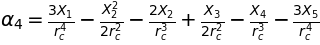

In [16]:
Eq(alpha[4],expand(sln[4]))

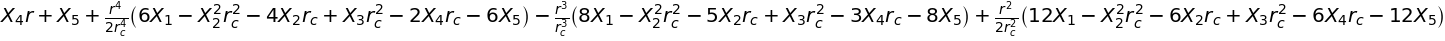

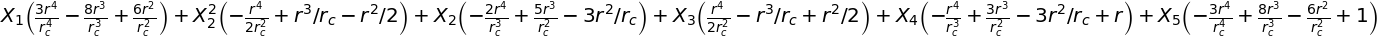

In [17]:
# Expand in terms of X's
p_X = p.subs({alpha[i]:sln[i] for i in range(5)})
display(p_X)
c_p_X = expand(p_X)
for sym in [X5, X4, X3, X2, X1]:
    c_p_X = collect(c_p_X, sym)
display(c_p_X)

 ### Effective local energy
 
 Fit this to an 'ideal local energy' to get the final parameter

In [18]:
def del_spherical(e, r):
    """Compute Laplacian for expression e with respect to symbol r.
        Currently works only with radial dependence"""
    t1 = r*r*diff(e, r)
    t2 = diff(t1, r)/(r*r)
    return simplify(t2)

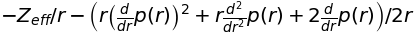

In [19]:
# Effective one-electron local energy
p_sym = Symbol('p')
phi_tilde = exp(p_sym(r))
Zeff = Symbol('Z_eff')
El = -S.Half * del_spherical(phi_tilde, r)/phi_tilde - Zeff/r
#print R_def
#print del_spherical(R_def, r)
display(El)
El_sym = El.subs(p_sym(r), p).doit()
El_sym

In [20]:
def eval_local_energy(gto, alpha_vals, r_val, Zeff_val):
    slist = {alpha[0]:alpha_vals[0], alpha[1]:alpha_vals[1], alpha[2]: alpha_vals[2], alpha[3]:alpha_vals[3],
           alpha[4]:alpha_vals[4], Zeff:Zeff_val, r:r_val}
    return El_sym.subs(slist).evalf()

In [21]:
def get_current_local_energy(gto, xs, rc_val, alpha_vals, Zeff_val):
    EL_curr = []
    EL_at_rc = eval_local_energy(gto, alpha_vals, rc_val, Zeff_val)
    dE = -EL_at_rc
    #print 'dE = ',dE
    for x in xs:
        if x < rc_val:
            el = eval_local_energy(gto, alpha_vals, x, Zeff_val)
            EL_curr.append(el + dE)
        else:
            val, grad, lap = [g[0] for g in gto.eval_vgl(x, 0.0, 0.0)]
            real_el = -.5*lap / val - Zeff_val/x
            EL_curr.append(real_el + dE)
    return EL_curr
            
        

### Evaluate for He orbital

In [22]:
basis_set, he_MO = read_qmcpack.parse_qmc_wf('he_sto3g.wfj.xml',['He'])
he_gto = gaussian_orbitals.GTO(basis_set['He'])
rc_val = 0.1
he_Z_val = 2.0


MO coeff size =  1


In [23]:
xvals = np.linspace(start=-2.0, stop=2.0, num=40)
yvals = np.array([he_gto.eval_v(x, 0.0, 0.0)[0] for x in xvals])
he_gto.eval_v(1.1, 0.0, 0.0)

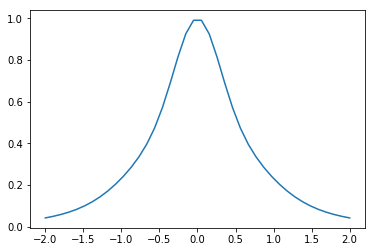

In [24]:
plt.plot(xvals, yvals)

In [25]:
def compute_EL(X5_val):
    xslist = {X1:X1_val, X2:X2_val, X3:X3_val, X4:X4_val, X5:X5_val, rc:rc_val}
    alpha_vals = [s.subs(xslist) for s in sln]
    aslist = {alpha0:alpha_vals[0], alpha1:alpha_vals[1], alpha2:alpha_vals[2], alpha3:alpha_vals[3],
          alpha4:alpha_vals[4], Zeff:Zeff_val}
    Elof_r = El.subs(aslist)
    return Elof_r

In [26]:
xs = np.linspace(start=0.012, stop=1.2*rc_val, num=10)
xs

array([0.012, 0.024, 0.036, 0.048, 0.06 , 0.072, 0.084, 0.096, 0.108,
       0.12 ])

Coefficients from the paper to fit an 'ideal' effective one-electron local energy

In [27]:
beta0 = Symbol('beta_0')
beta_vals = [beta0, 3.25819, -15.0126, 33.7308, -42.8705, 31.2276, -12.1316, 1.94692]

In [28]:
El_terms = [beta_vals[n]*r**(n+1) for n in range(1,8)]
EL_ideal_sym = beta0 + sum(El_terms)
EL_ideal_sym


In [29]:
# Compute ideal local energy at a point
def compute_ideal_EL(r_val, Z_val, beta0_val=0.0):
    Z = Symbol('Z')
    slist = {beta0: beta0_val, Z:Z_val, r:r_val}
    return (Z*Z*EL_ideal_sym).subs(slist).evalf()

In [30]:
# Choose beta_0
El_orig_at_rc = compute_ideal_EL(rc_val, he_Z_val)
Z_val = he_Z_val
print 'EL orig at r_c',El_orig_at_rc
beta0_val = -(El_orig_at_rc)/Z_val/Z_val
beta0_val

EL orig at r_c 0.0821748356368000


In [31]:
EL_ideal = [compute_ideal_EL(rval,he_Z_val, beta0_val) for rval in xs]
EL_ideal

In [32]:
# Evaluate values of X's
def evalX(phi_func, rc_val, C_val, Z_val, phi_at_zero, eta_at_zero=0.0):
    X = [0.0]*5
    phi_at_rc, grad_at_rc, lapl_at_rc = phi_func(rc_val)
    X[0] = log(abs(phi_at_rc - C_val))
    X[1] = grad_at_rc[0] / (phi_at_rc - C_val)
    X[2] = (lapl_at_rc - 2.0*grad_at_rc[0]/rc_val)/(phi_at_rc - C_val)
    X[3] = -Z_val * (phi_at_zero + eta_at_zero) / (phi_at_zero - C_val)
    X[4] = log(abs(phi_at_zero - C_val))
    return X

In [33]:
def create_phi_func(gto):
    def phi_func(r_val):
        val,grad,lap = gto.eval_vgl(r_val, 0.0, 0.0)
        return val[0], grad[0], lap[0]
    
    return phi_func

In [34]:
Xvals = [0.0]*5
C_val = 0.0
he_Z_val = 2.0
he_phi = create_phi_func(he_gto)
evalX(he_phi, rc_val, C_val, he_Z_val, he_phi(0.0)[0])

In [35]:
def solve_for_alpha(Xvals):
    xslist = {X1:Xvals[0], X2:Xvals[1], X3:Xvals[2], X4:Xvals[3], X5:Xvals[4], rc:rc_val}
    alpha_vals = [s.subs(xslist) for s in sln]
    return alpha_vals

In [36]:
he_alpha_vals = solve_for_alpha(Xvals)

In [37]:
print rc_val

0.1


In [38]:
EL_curr = get_current_local_energy(he_gto, xs, rc_val, he_alpha_vals, he_Z_val)
EL_curr

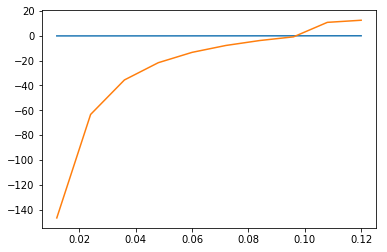

In [39]:
plt.plot(xs, EL_ideal, xs, EL_curr)

In [40]:
def compute_chi2(EL_ideal, EL_curr):
    return sum([(e1-e2)**2 for e1,e2 in zip(EL_ideal, EL_curr)])

In [41]:
compute_chi2(EL_ideal, EL_curr)

In [42]:
def compute_one_cycle(phi_func, gto, rc_val, Z_val, phi_at_zero, eta_at_zero=0.0):
    C_val = 0.0
    X = evalX(phi_func, rc_val, C_val, Z_val, phi_at_zero, eta_at_zero)
    alpha_vals = solve_for_alpha(X)
    EL_curr = get_current_local_energy(he_gto, xs, rc_val, alpha_vals, Z_val)
    chi2 = compute_chi2(EL_ideal, EL_curr)
    return chi2, alpha_vals, EL_curr
    
    

In [43]:
phi_at_zero = he_phi(0.0)[0]
EL_curr = []
for ioffset in range(10):
    chi2, alpha_vals, EL_curr = compute_one_cycle(he_phi, he_gto, rc_val, he_Z_val, phi_at_zero+.01*ioffset)
    print chi2

25854.2846426019
21111.8921728781
16918.8592218111
13256.3864130293
10106.4199357371
7451.61627411234
5275.30889319427
3561.47675650037
2294.71455959869
1460.20457213250


<IPython.core.display.Javascript object>


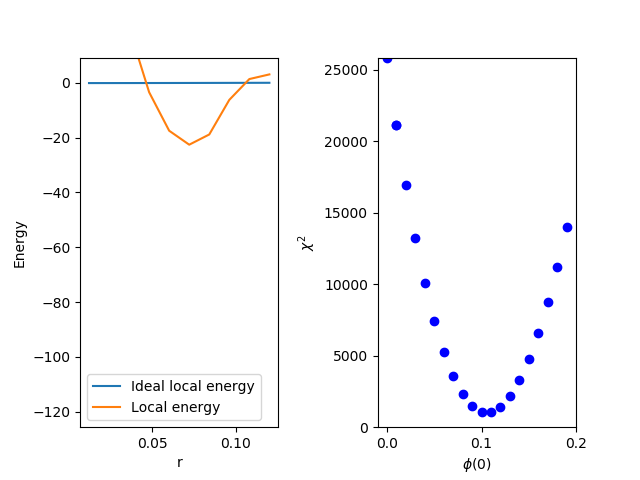

In [56]:
# See the local energy and ideal local energy change as phi(0) changes

fig, ax = plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.5)
chi2, alpha_vals, EL_curr = compute_one_cycle(he_phi, he_gto, rc_val, he_Z_val, phi_at_zero)
chi2 = float(chi2)
ax[0].plot(xs, EL_ideal,label="Ideal local energy")
ax[0].set_ylabel("Energy")
ax[0].set_xlabel("r")
line, = ax[0].plot(xs, EL_curr, label="Local energy")
ax[0].legend()
chis = [chi2]
offsets = [0.0]
ax[1].set_xlim(-0.01, 20*0.01)
ax[1].set_ylim(0.0, chi2)
ax[1].set_ylabel("$\chi^2$")
ax[1].set_xlabel("$\phi(0)$")
line_chi, = ax[1].plot(offsets, chis, 'bo')


def animate_chi2(ioffset):
    offset = ioffset*0.01
    chi2, alpha_vals, EL_curr = compute_one_cycle(he_phi, he_gto, rc_val, he_Z_val, phi_at_zero + offset)
    print chi2, offset
    line.set_ydata(EL_curr)
    offsets.append(offset)
    chis.append(chi2)
    line_chi.set_xdata(offsets)
    line_chi.set_ydata(chis)
    #line_chi.plot(offsets, chis)
    return line,
    
# Uncomment the following to see the animation    
#ani = animation.FuncAnimation(fig, animate_chi2, np.arange(1,20), interval=100, blit=True, repeat=False)
#plt.show()

0.1


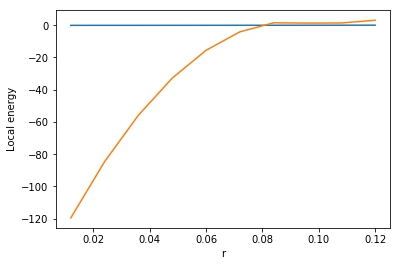

In [45]:
# Interactive plot with r_c and phi(0) adjustable
phi_slider = ipywidgets.FloatSlider(value=phi_at_zero, min=phi_at_zero/2.0, max=phi_at_zero*2.0)
rc_slider = ipywidgets.FloatSlider(value=rc_val,min=rc_val/1.5,max=rc_val*1.5)
print rc_val
#plt.plot(xs, EL_curr, xs, EL_ideal)
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.set_xlabel("r")
ax2.set_ylabel("Local energy")
line2, = ax2.plot(xs,EL_ideal)
line3, = ax2.plot(xs, EL_curr)

def update(phi0=1.0, rc_new=0.1):
    chi2, alpha_vals, EL_curr = compute_one_cycle(he_phi, he_gto, rc_new, he_Z_val, phi0)
    line3.set_ydata(EL_curr)
    fig2.canvas.draw()

# Uncomment to activate the interactive version
#interact(update, phi0 = phi_slider, rc_new=rc_slider)
    

In [46]:
def chi2_opt(x):
    phi_at_zero = x[0]
    rc_val = x[1]
    chi2, alpha_vals, EL_curr = compute_one_cycle(he_phi, he_gto, rc_val, he_Z_val, phi_at_zero)
    return float(chi2)

phi_at_zero = float(he_phi(0.0)[0])
print 'starting phi(0) = ',phi_at_zero
# Optimize phi_0 and rc simultaneously
# This optimization to find the minimum chi2 can take a while. 
scipy.optimize.minimize(chi2_opt,[phi_at_zero, rc_val])

starting phi(0) =  0.999603733514


      fun: 7.740763089368863
 hess_inv: array([[ 4.37122586e-05, -3.53898845e-05],
       [-3.53898845e-05,  2.86520112e-05]])
      jac: array([-15512.01509583, -19156.76275462])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 1128
      nit: 127
     njev: 279
   status: 2
  success: False
        x: array([0.66675309, 0.48046938])

### Dividing the wavefunction
 Into $\phi$ and $\eta$ pieces.  This is done in QMCPACK by writing zeros to the coefficient matrix.
 

In [47]:
# For Neon with DEF2-SVP
ne_basis_set, ne_MO_matrix = read_qmcpack.parse_qmc_wf('ne_def2_svp.wfnoj.xml',['Ne'])
#for cg in ne_basis_set:
#    print cg
    
print ne_MO_matrix.shape
#ne_MO_matrix
ne_basis_set['Ne']

MO coeff size =  14
(14, 15)


In [48]:
c_phi = ne_MO_matrix.copy()
c_eta = ne_MO_matrix.copy()
basis_by_index = gaussian_orbitals.get_ijk_inverse_index(ne_basis_set['Ne'])
# Loop over MO
for mo_idx in range(ne_MO_matrix.shape[0]):
  
    for ao_idx in range(ne_MO_matrix.shape[1]):
        # Loop over centers (for Ne atom, there is only one)
        # If s-type
        basis_set, angular_info = basis_by_index[mo_idx]
        if basis_set.orbtype == 0:
            # s-type, part of phi but not eta
            c_eta[mo_idx, ao_idx] = 0.0
        else:
            # not s-type, part of eta but not phi
            c_phi[mo_idx, ao_idx] = 0.0

In [49]:
c_phi

array([[ 0.990133, -0.031233,  0.009072,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ],
       [ 0.322026,  0.643777,  0.460567, -0.      , -0.      , -0.      ,
        -0.      , -0.      , -0.      , -0.      , -0.      , -0.      ,
        -0.      , -0.      , -0.      ],
       [-0.      , -0.      , -0.      ,  0.697249, -0.      , -0.      ,
        -0.454527, -0.      , -0.      , -0.      , -0.      , -0.      ,
        -0.      , -0.      , -0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      

In [50]:
ne_phi_mo = gaussian_orbitals.MO(gaussian_orbitals.GTO(ne_basis_set['Ne']), c_phi)
ne_phi_mo.eval_v(0.0, 0.0, 0.0)

array([-16.11819129,  -4.48709323,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

In [51]:
ne_eta_mo = gaussian_orbitals.MO(gaussian_orbitals.GTO(ne_basis_set['Ne']), c_eta)
ne_eta_mo.eval_v(0.0, 0.0, 0.0)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -4.47043866,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [52]:
mo_idx = 0
gto1 = gaussian_orbitals.GTO(ne_basis_set['Ne'][mo_idx:mo_idx+1])
ne_phi_mo1 = gaussian_orbitals.MO(gaussian_orbitals.GTO(ne_basis_set['Ne']), c_phi[mo_idx:mo_idx+1,:])
print ne_phi_mo1.eval_v(0.0, 0.0, 0.0)

ne_eta_mo1 = gaussian_orbitals.MO(gaussian_orbitals.GTO(ne_basis_set['Ne']), c_eta[mo_idx:mo_idx+1,:])
print ne_eta_mo1.eval_v(0.0, 0.0, 0.0)

[-16.11819129]
[0.]


In [53]:
Xvals = [0.0]*5
C_val = 0.0
ne_Z_val = 10.0
ne_phi = create_phi_func(ne_phi_mo1)
ne_eta_at_zero = ne_eta_mo1.eval_v(0.0,0.0,0.0)[0]
evalX(ne_phi, rc_val, C_val, ne_Z_val, ne_phi(0.0)[0], ne_eta_at_zero)